In [98]:
import numpy as np
import pandas as pd
import random
import queue
import copy
from collections import defaultdict

class KNN:
    def __init__(self, raw_data):
        self.raw_data = raw_data

    def train(self):
        (self.data, self.mean, self.std) = self.normalize(self.raw_data.drop(columns = 'class'))
        self.data['class'] = self.raw_data['class']
        # self.data = self.raw_data
        
        
    
    def normalize(self, data):
        data_mean = data.mean(axis = 0)
        data_std = data.std(axis = 0)     

        norm_data = (data - data_mean) / data_std
        return (norm_data, data_mean, data_std)

    # Returns class of closest point
    def test(self, point, k = 1):
        # Normalize point
        norm_point = (point - self.mean) / self.std
        # norm_point = point #unnormalized
        kmin_distances = np.argsort(self.distances(norm_point))[:k]
        class_label = self.data.iloc[kmin_distances]['class']
        return np.argmax(np.bincount(class_label))

    # Euclidean distance
    def distances(self, point):
        return np.sum((self.data.drop(columns = 'class') - point) ** 2, axis = 1)

class Validator:
    def __init__(self, data, k = 1):
        self.data = data
        self.k = k

    def leave_one_out(self):
        prediction = 0
        total_instances = len(self.data)

        for i in range(total_instances):
            training_data = self.data.drop(i)
            test_instance = self.data.iloc[i]
            classifier = KNN(training_data)
            classifier.train()
            predicted_class = classifier.test(test_instance.drop('class'), self.k)
            actual_class = test_instance['class']

            if predicted_class == actual_class:
                prediction +=1
        
        accuracy = prediction/total_instances
        return accuracy


In [99]:
class Node:
    def __init__(self, state: set, parent, accuracy):
        self.state = state
        self.parent = parent
        self.accuracy = accuracy

    def printstate(self):
        print(self.state)

    def evaluate(self, data, k = 1):
        evalu = Validator(data[list(self.state) + ['class']], k)
        self.accuracy = evalu.leave_one_out()

class FeatureSearch:
    def __init__(self, data, k = 1):
        self.data = data
        self.total_features = len(self.data.columns) - 1
        self.k = k

    def expand_node_fs(self, node):
        children = []
        current_features = set(node.state)
        for feature in range(1, self.total_features + 1):
            if feature not in current_features:
                new_state = set(node.state)
                new_state.add(feature)
                child_node = Node(state = new_state, parent = node, accuracy = 0)
                child_node.evaluate(self.data, self.k)
                children.append(child_node)
        return children

    def expand_node_be(self, node):
        children = []
        current_features = set(node.state)
        for feature in range(1, self.total_features + 1):
            if feature in current_features:
                new_state = set(node.state)
                new_state.remove(feature)
                child_node = Node(state = new_state, parent = node, accuracy = 0)
                child_node.evaluate(self.data, self.k)
                children.append(child_node)
        return children

    def forward_selection(self):
        root = Node(state = {}, parent = None, accuracy = 0)
        root.evaluate(self.data)
        best_node = root
        currnode = root
        goalstate = {i for i in range(1, self.total_features + 1)}

        print(f"Using no features and leave-one-out evaluation, I get an accuracy of {round(root.accuracy * 100, 2)}%\n")
        print("Beginning search\n")
        while currnode.state != goalstate:
            children = self.expand_node_fs(currnode)
            curr_best_node = children[0]
            for child in children:
                print(f"\tUsing feature(s) {child.state} accuracy is {round(child.accuracy * 100, 2)}%")
                if child.accuracy > curr_best_node.accuracy:
                    curr_best_node = child
            currnode = curr_best_node
            print(f"\nFeature set {currnode.state} was best, accuracy is {round(currnode.accuracy * 100, 2)}%\n")
            if currnode.accuracy > best_node.accuracy:
                best_node = currnode
            else:
                print("Warning: Accuracy has decreased, still continuing search\n")
        print(f"Finished search!!! The best feature set is {best_node.state} with an accuracy of {round(best_node.accuracy * 100, 2)}%")
        return round(best_node.accuracy * 100, 2)

    def backward_elimination(self,):
        startstate = {i for i in range(1, self.total_features + 1)}
        root = Node(state = startstate, parent = None, accuracy = 0)
        root.evaluate(self.data)
        best_node = root
        currnode = root
        print(f"Using all features and feature set {root.state} and leave-one-out evaluation, I get an accuracy of {round(root.accuracy * 100, 2)}%\n")
        print("Beginning search\n")
        while currnode.state != set({}):
            children = self.expand_node_be(currnode)
            curr_best_node = children[0]
            for child in children:
                print(f"\tUsing feature(s) {child.state} accuracy is {round(child.accuracy * 100, 2)}%")
                if child.accuracy > curr_best_node.accuracy:
                    curr_best_node = child
            currnode = curr_best_node
            print(f"\nFeature set {currnode.state} was best, accuracy is {round(currnode.accuracy * 100, 2)}%\n")
            if currnode.accuracy > best_node.accuracy:
                best_node = currnode
            else:
                print("Warning: Accuracy has decreased, still continuing search\n")
        print(f"Finished search!!! The best feature set is {best_node.state} with an accuracy of {round(best_node.accuracy * 100, 2)}%")
        return round(best_node.accuracy * 100, 2)

def read_file(filename):
    try:
        file = open(filename, "r")
        lines = file.readlines()
    except:
        print("File not found!")
        exit(1)

    data = [line.split() for line in lines]
    data = np.array(data).astype(float)

    classes = data[:, 0]
    features = data[:, 1:]

    data_dict = {(i+1): features[:, i] for i in range(features.shape[1])}
    data_dict['class'] = classes
    
    return pd.DataFrame(data_dict)

In [100]:
data = read_file("CS170_Spring_2024_Small_Data__1.txt")
data.describe()

,1,2,3,4,5,6,7,8,9,10,class
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.000352,-0.095747,0.025012,0.021837,-0.054242,0.023211,-0.062929,0.098801,0.229303,0.212190,1.860000
std,1.079592,1.042513,0.961098,1.000736,1.122592,1.028868,1.095114,0.932704,0.904476,0.979607,0.348735
min,-3.376864,-2.729580,-2.100193,-2.138747,-2.941360,-1.981336,-2.741559,-1.874638,-2.311470,-1.919852,1.000000
25%,-0.714168,-0.759281,-0.478510,-0.641154,-0.801545,-0.664339,-0.883988,-0.483176,-0.373614,-0.495134,2.000000
50%,-0.036718,-0.025382,-0.058638,0.007757,-0.055008,-0.046487,-0.051817,-0.012654,0.216729,0.242986,2.000000
75%,0.780916,0.552040,0.551472,0.638570,0.644296,0.560034,0.642169,0.677910,0.779436,0.886984,2.000000
max,2.287902,2.952435,2.406851,3.420251,3.070352,2.654415,2.776844,3.107228,3.298151,2.431644,2.000000


In [14]:
search = FeatureSearch(data)

In [23]:
fs = []
be = []
k_vals = []
for k in range(1, 100, 2):
    k_vals.append(k)
    search = FeatureSearch(data, k)
    fs.append(search.forward_selection())
    be.append(search.backward_elimination())
    print(k)
    print(fs)
    print(be)

Using no features and leave-one-out evaluation, I get an accuracy of 86.0%

Beginning search

	Using feature(s) {1} accuracy is 84.0%
	Using feature(s) {2} accuracy is 79.0%
	Using feature(s) {3} accuracy is 76.0%
	Using feature(s) {4} accuracy is 77.0%
	Using feature(s) {5} accuracy is 78.0%
	Using feature(s) {6} accuracy is 75.0%
	Using feature(s) {7} accuracy is 90.0%
	Using feature(s) {8} accuracy is 80.0%
	Using feature(s) {9} accuracy is 77.0%
	Using feature(s) {10} accuracy is 79.0%

Feature set {7} was best, accuracy is 90.0%

	Using feature(s) {1, 7} accuracy is 79.0%
	Using feature(s) {2, 7} accuracy is 85.0%
	Using feature(s) {3, 7} accuracy is 89.0%
	Using feature(s) {4, 7} accuracy is 83.0%
	Using feature(s) {5, 7} accuracy is 97.0%
	Using feature(s) {6, 7} accuracy is 85.0%
	Using feature(s) {8, 7} accuracy is 86.0%
	Using feature(s) {9, 7} accuracy is 84.0%
	Using feature(s) {10, 7} accuracy is 84.0%

Feature set {5, 7} was best, accuracy is 97.0%

	Using feature(s) {1, 

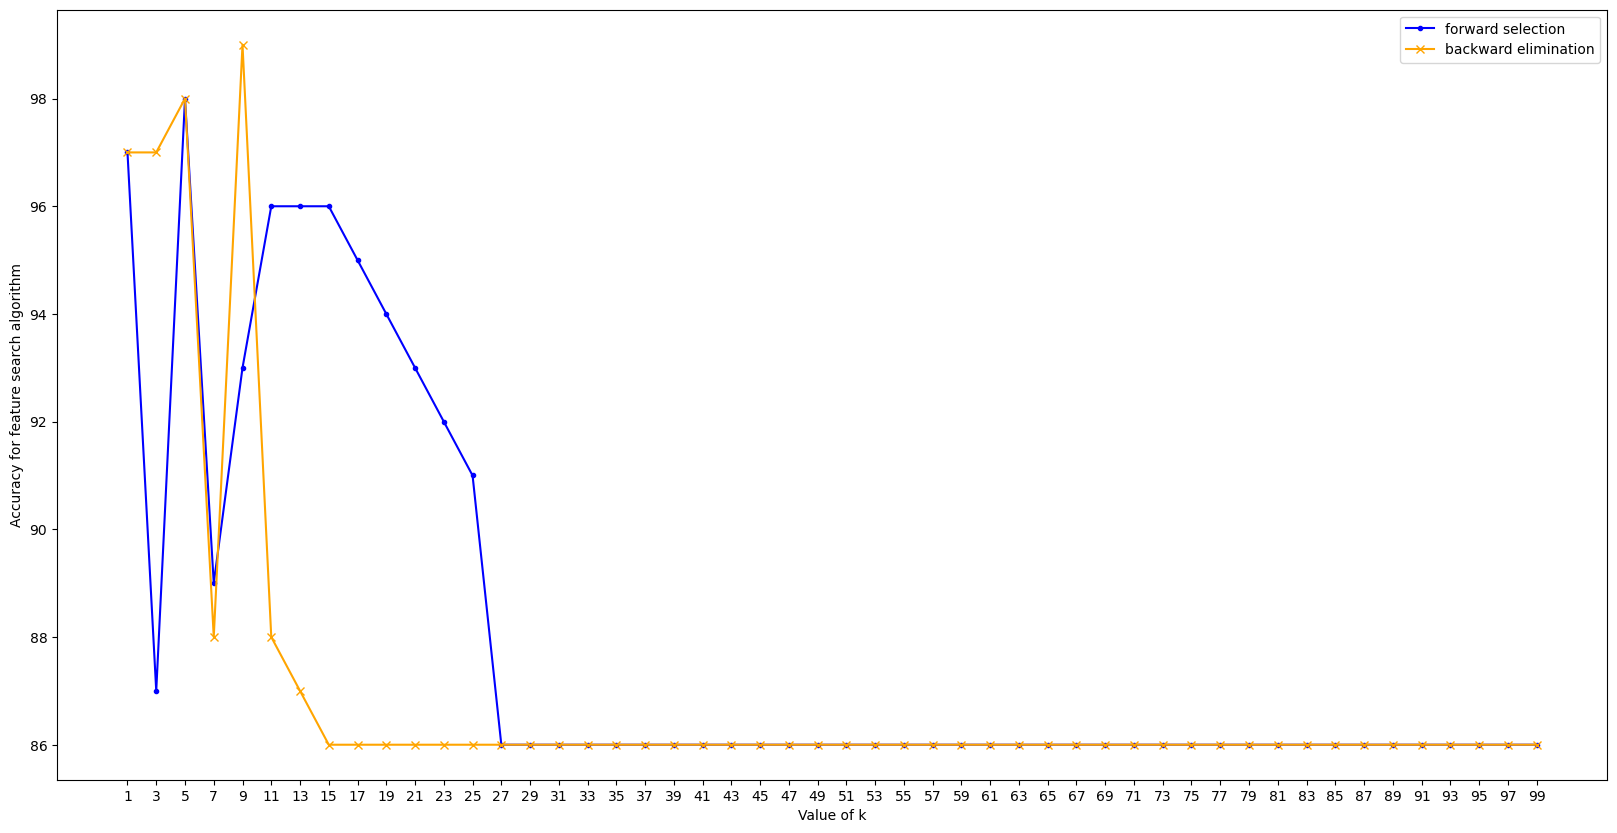

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
plt.plot(k_vals, fs, label = "forward selection", color = 'b', marker = '.')
plt.plot(k_vals, be, label = "backward elimination", color = 'orange', marker = 'x')
plt.legend()
plt.xticks(k_vals)
plt.xlabel('Value of k')
plt.ylabel('Accuracy for feature search algorithm')
plt.savefig('knn_feature_search.png')

In [97]:
# fs

In [87]:
search = FeatureSearch(data)

In [101]:
search.forward_selection()

Using no features and leave-one-out evaluation, I get an accuracy of 86.0%

Beginning search

	Using feature(s) {1} accuracy is 84.0%
	Using feature(s) {2} accuracy is 79.0%
	Using feature(s) {3} accuracy is 76.0%
	Using feature(s) {4} accuracy is 77.0%
	Using feature(s) {5} accuracy is 78.0%
	Using feature(s) {6} accuracy is 75.0%
	Using feature(s) {7} accuracy is 90.0%
	Using feature(s) {8} accuracy is 80.0%
	Using feature(s) {9} accuracy is 77.0%
	Using feature(s) {10} accuracy is 79.0%

Feature set {7} was best, accuracy is 90.0%

	Using feature(s) {1, 7} accuracy is 79.0%
	Using feature(s) {2, 7} accuracy is 85.0%
	Using feature(s) {3, 7} accuracy is 89.0%
	Using feature(s) {4, 7} accuracy is 83.0%
	Using feature(s) {5, 7} accuracy is 97.0%
	Using feature(s) {6, 7} accuracy is 85.0%
	Using feature(s) {8, 7} accuracy is 86.0%
	Using feature(s) {9, 7} accuracy is 84.0%
	Using feature(s) {10, 7} accuracy is 84.0%

Feature set {5, 7} was best, accuracy is 97.0%

	Using feature(s) {1, 

97.0

In [ ]:
search.backward_elimination()

In [57]:
v = Validator(data)

In [58]:
v.leave_one_out()

0.79

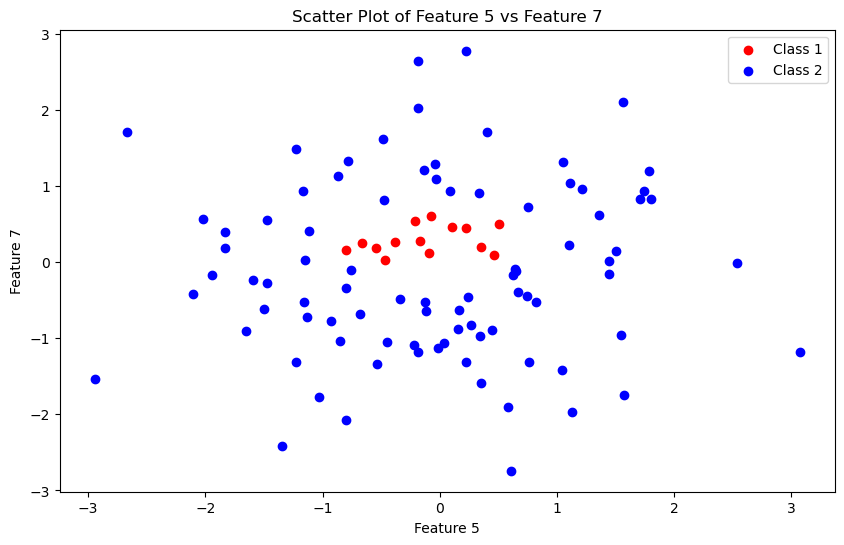

In [68]:
class_1 = data[data['class'] == 1]
class_2 = data[data['class'] == 2]

# Plot the data
plt.figure(figsize=(10, 6))

plt.scatter(class_1[5], class_1[7], color='red', label='Class 1')
plt.scatter(class_2[5], class_2[7], color='blue', label='Class 2')

plt.xlabel('Feature 5')
plt.ylabel('Feature 7')
plt.title(f'Scatter Plot of Feature 5 vs Feature 7')
plt.legend()
plt.show()

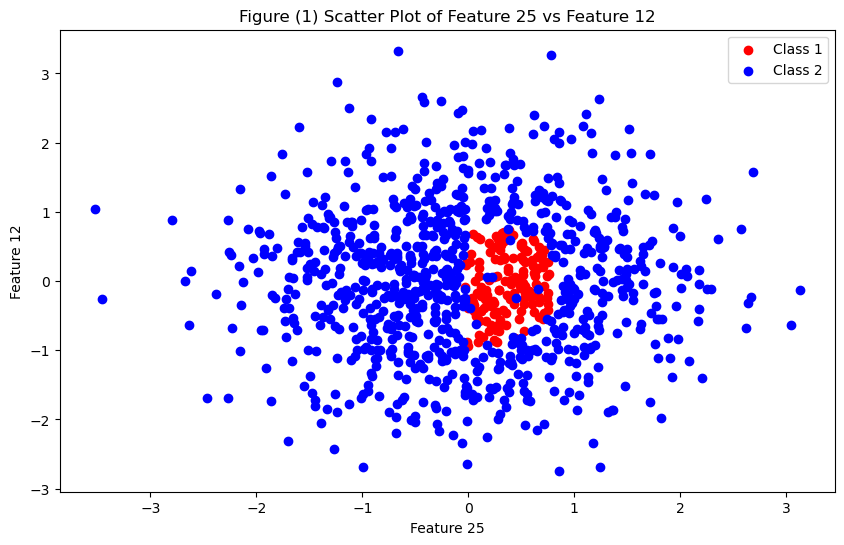

In [96]:
def normalize(data):
    data_mean = data.mean(axis = 0)
    data_std = data.std(axis = 0)     
    norm_data = (data - data_mean) / data_std
    return norm_data

data = read_file("CS170_Spring_2024_Large_Data__1.txt")

norm_data = normalize(data)
norm_data['class'] = data['class']

class_1 = norm_data[norm_data['class'] == 1]
class_2 = norm_data[norm_data['class'] == 2]

# Plot the data
plt.figure(figsize=(10, 6))

plt.scatter(class_1[25], class_1[12], color='red', label='Class 1')
plt.scatter(class_2[25], class_2[12], color='blue', label='Class 2')

plt.xlabel('Feature 25')
plt.ylabel('Feature 12')
plt.title(f'Figure (1) Scatter Plot of Feature 25 vs Feature 12')
plt.legend()
plt.savefig('ft25vsft12.png')